In [1]:
import os
import random
import argparse
import itertools
import numpy as np
from os import listdir
from os.path import join
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf 

import torch
import torchvision
import torch.nn as nn
from torch.nn import init
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

/home/youngju/anaconda3/envs/proto/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = 'supervised_v1'
path_result = f'/data2/youngju/CycleGAN/Submission/CT_denoising' # the path of the checkpoint

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--path-data", type=str, default="/data2/youngju/CycleGAN/AAPM_data")
parser.add_argument("--model-name", type=str, default="supervised_v1")
parser.add_argument("--num_epoch", type=int, default=20)
parser.add_argument("--batch-size", type=int, default=4)
parser.add_argument("--lr", type=float, default=2e-4)
parser.add_argument("--seed", type=int, default=0)
parser.add_argument("--device", type=str, default="cuda:5")
parser.add_argument("--G_ngf", type=int, default=32)
parser.add_argument("--G_n_res_blocks", type=int, default=6)
parser.add_argument("--beta1", type=float, default=0.5)
parser.add_argument("--beta2", type=float, default=0.999)

args = parser.parse_args(args=[])

In [4]:
path_loss = f'{path_result}/loss'
for name in ['sup_loss']:
  loss_arr = torch.load(join(path_loss, name + '.npy'))
  num_epoch = len(loss_arr)
  break

In [5]:
import random
from os import listdir
from os.path import join
from torch.utils.data import Dataset


# CT dataset
class CT_Dataset(Dataset):
  def __init__(self, path, transform):
    # Path of 'full_dose' and 'quarter_dose' folders
    self.path_full = join(path, 'full_dose')
    self.path_quarter = join(path, 'quarter_dose')
    self.transform = transform

    # File list of full dose data
    self.file_full = list()
    for file_name in sorted(listdir(self.path_full)):
      self.file_full.append(file_name)
    # random.seed(0)
    # random.shuffle(self.file_full)
    
    # File list of quarter dose data
    self.file_quarter = list()
    for file_name in sorted(listdir(self.path_quarter)):
      self.file_quarter.append(file_name)
  
  def __len__(self):
    return min(len(self.file_full), len(self.file_quarter))
  
  def __getitem__(self, idx):
    # Load full dose/quarter dose data
    x_F = np.load(join(self.path_full, self.file_full[idx]))
    x_Q = np.load(join(self.path_quarter, self.file_quarter[idx]))

    # Convert to HU scale
    x_F = (x_F - 0.0192) / 0.0192 * 1000
    x_Q = (x_Q - 0.0192) / 0.0192 * 1000

    # Normalize images
    x_F[x_F < -1000] = -1000
    x_Q[x_Q < -1000] = -1000

    x_F = x_F / 4000
    x_Q = x_Q / 4000

    # Apply transform
    x_F = self.transform(x_F)
    x_Q = self.transform(x_Q)

    file_name = self.file_quarter[idx]

    return x_F, x_Q, file_name

In [6]:
import random
import torchvision
from torch.utils.data import DataLoader


# Transform for the random crop
class RandomCrop(object):
  def __init__(self, patch_size):
    self.patch_size = patch_size
  
  def __call__(self, img):
    # Randomly crop the image into a patch with the size [self.patch_size, self.patch_size]
    w, h = img.size(-1), img.size(-2)
    i = random.randint(0, h - self.patch_size)
    j = random.randint(0, w - self.patch_size)

    return img[:, i:i + self.patch_size, j:j + self.patch_size]


# Make dataloader for training/test
def make_dataloader(path, batch_size):
  # Path of 'train' and 'test' folders
  path_train = join(path, 'train')
  path_test = join(path, 'test')

  # Transform for training data: convert to tensor, random horizontal/verical flip, random crop
  # You can change transform if you want.
  train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    RandomCrop(128)
  ])

  # Transform for test data: convert to tensor
  test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
  ])

  # Generate CT dataset for training/test
  train_dataset = CT_Dataset(path_train, train_transform)
  test_dataset = CT_Dataset(path_test, test_transform)
  
  # Generate dataloader for training/test
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
  test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

  return train_dataloader, test_dataloader

In [7]:
class ResnetBlock(torch.nn.Module):
    def __init__(self, n_channels):
        super(ResnetBlock, self).__init__()
        # Resnet-based Block
        self.res_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_channels, n_channels, kernel_size=3),
            nn.InstanceNorm2d(n_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_channels, n_channels, kernel_size=3),
            nn.InstanceNorm2d(n_channels),
        )

    def forward(self, x):
        out = x + self.res_block(x)
        return out

class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(ConvBlock, self).__init__()
        # includes two convolution layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU()
        )
  
    def forward(self, x):
        out = self.conv(x)
        return out
  

class DeconvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(DeconvBlock, self).__init__()
        # includes two transposed-convolution layers
        self.deconv = nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(mid_channels),
            nn.ReLU(),
            torch.nn.ConvTranspose2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.deconv(x)
        return out


class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, ngf, n_res_blocks):
        super(Generator, self).__init__()
        # in_channels: the number of channels of the input
        # ngf: the number of convolution filters of the first layer
        # out_channels: the number of channels of the output
        # n_res_blocks: the number of the resnet-based blocks
        self.ngf = ngf
        self.first_layer = nn.Sequential(nn.ReflectionPad2d(3),
                                         nn.Conv2d(in_channels, ngf, 7),
                                         nn.InstanceNorm2d(ngf),
                                         nn.ReLU(inplace=True))
        self.conv_block = ConvBlock(self.ngf, self.ngf*2, self.ngf*4)
        self.res_layers = nn.Sequential(*[ResnetBlock(self.ngf*4) for i in range(n_res_blocks)])
        self.deconv_block = DeconvBlock(self.ngf*4, self.ngf*2, self.ngf)
        self.last_layer = nn.Sequential(nn.ReflectionPad2d(3),
                                        nn.Conv2d(self.ngf, out_channels, 7),
                                        nn.Tanh()
                                        )
                                        
        
    def forward(self, x):
        
        h = self.first_layer(x)
        h = self.conv_block(h)
        h = self.res_layers(h)
        h = self.deconv_block(h)
        res = self.last_layer(h)

        # residual path
        out = res + x
        return out

In [8]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Functions for caculating PSNR, SSIM
def psnr(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = peak_signal_noise_ratio(ref, A)
  return out

def ssim(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = structural_similarity(ref, A, data_range=2)
  return out

# Loss Graph

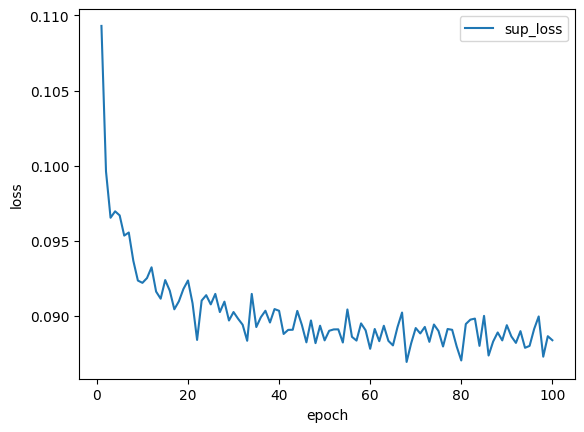

In [9]:
loss_path = f'{path_result}/loss_fig'
if not os.path.isdir(loss_path):
  os.makedirs(loss_path)
  
# Plot loss graph 
x_axis = np.arange(1, num_epoch + 1)
plt.figure(1)
for name in ['sup_loss']:
  loss_arr = torch.load(join(path_loss, name + '.npy'))
  plt.plot(x_axis, loss_arr[:num_epoch], label=name)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.savefig(join(loss_path, 'supervised_loss.png'))
plt.show()

# Quantitative Evaluation (PSNR/SSIM)

In [10]:
train_dataloader, test_dataloader = make_dataloader(args.path_data, args.batch_size)
G_ngf = args.G_ngf # the number of convolution filters of the first layer for Generator
n_res_blocks = args.G_n_res_blocks # the number of the ResNet-based blocks
in_channels = test_dataloader.dataset[0][0].shape[0]
out_channels = test_dataloader.dataset[0][0].shape[0]
G_Q2F = Generator(in_channels, out_channels, G_ngf, n_res_blocks).to(args.device)

In [11]:
# Load the checkpoint
checkpoint = torch.load(join(path_result, model_name + f'.pth'))
G_Q2F.load_state_dict(checkpoint['G_Q2F_state_dict'])
G_Q2F.eval()

save_path = f'{path_result}/supervised_test_outputs'
if not os.path.isdir(save_path):
  os.makedirs(save_path)

# Test and save
with torch.no_grad():
  for _, x_Q, file_name in tqdm(test_dataloader):
    x_Q = x_Q.to(args.device)
    x_QF = G_Q2F(x_Q)[0].detach().cpu().numpy()
    x_QF = x_QF * 4000

    np.save(join(save_path, file_name[0]), x_QF)

QF_psnr_list = []
QF_ssim_list = []
OF_psnr_list = []
OF_ssim_list = []

for num in tqdm(range(len(test_dataloader.dataset))):
  num = num+1
  path_quarter = join(args.path_data, f'test/quarter_dose/{num}.npy')
  path_full = join(args.path_data, f'test/full_dose/{num}.npy')
  path_output = join(save_path, f'{num}.npy')

  quarter = np.load(path_quarter)
  full = np.load(path_full)
  output = np.load(path_output)
  output = output.reshape(quarter.shape[0], quarter.shape[1])

  quarter = (quarter - 0.0192) / 0.0192 * 1000
  full = (full - 0.0192) / 0.0192 * 1000

  QF_psnr_list.append(psnr(quarter, full))
  QF_ssim_list.append(ssim(quarter, full))
  OF_psnr_list.append(psnr(output, full))
  OF_ssim_list.append(ssim(output, full))
  
print(f'🔥 Mean PSNR between input and ground truth:  {np.mean(QF_psnr_list)}')
print(f'🔥 Mean SSIM between input and ground truth:  {np.mean(QF_ssim_list)}')
print(f'🔥 Mean PSNR between output and ground truth:  {np.mean(OF_psnr_list)}')
print(f'🔥 Mean SSIM between output and ground truth:  {np.mean(OF_ssim_list)}')


100%|██████████| 421/421 [00:17<00:00, 24.41it/s]

🔥 Mean PSNR between input and ground truth:  34.16952392478545
🔥 Mean SSIM between input and ground truth:  0.8931997874844594
🔥 Mean PSNR between output and ground truth:  14.138338914660011
🔥 Mean SSIM between output and ground truth:  0.38079941879140095


# Qualitative evaluation

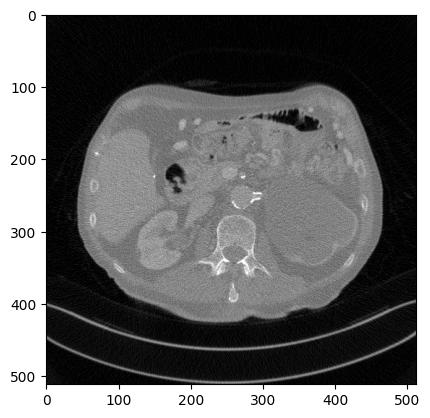

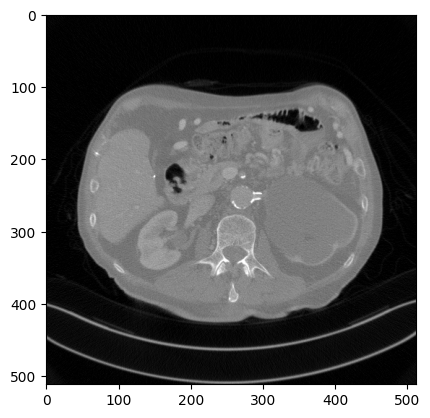

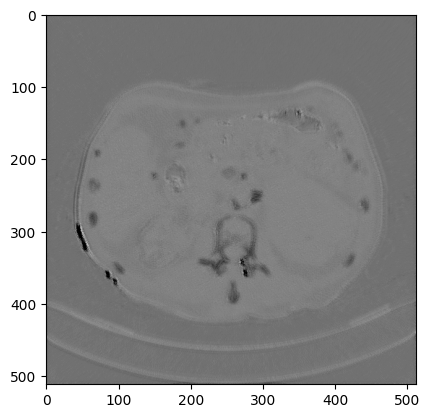

In [12]:
img_num = 100 # select the image
path_quarter = join(args.path_data, f'test/quarter_dose/{img_num}.npy')
path_full = join(args.path_data, f'test/full_dose/{img_num}.npy')
path_output = join(save_path, f'{img_num}.npy')

quarter = np.load(path_quarter)
full = np.load(path_full)
output = np.load(path_output)

quarter = (quarter - 0.0192) / 0.0192 * 1000
full = (full - 0.0192) / 0.0192 * 1000

quarter = np.clip(quarter, -1000, 1000)
full = np.clip(full, -1000, 1000)
output = np.clip(output, -1000, 1000)

plt.imshow(quarter, cmap='gray')
plt.show()
plt.imshow(full, cmap='gray')
plt.show()
plt.imshow(output.reshape(quarter.shape[0], quarter.shape[1]), cmap='gray')
plt.show()